In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


# Exploration des données

In [2]:
df_freq = pd.read_csv('firstname_with_sex.csv', sep=';')

print(df_freq.head())

  firstname     male   female
0     marie    10145  2390322
1      jean  1869615     6476
2    pierre  1475841     5047
3    jeanne     1765  1097397
4  françois  1089009     5951


In [3]:
df_freq.shape

(6946, 3)

In [4]:
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   firstname  6946 non-null   object
 1   male       6946 non-null   int64 
 2   female     6946 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 162.9+ KB


In [5]:
#Verification des valeurs manquantes
print(df_freq.isnull().sum())

firstname    0
male         0
female       0
dtype: int64


In [6]:
duplicates = df_freq.duplicated()

#nombre de doublons
print(f'Nombre de doublons: {duplicates.sum()}')

# lignes en double
if duplicates.any():
    print(df_freq[duplicates])

Nombre de doublons: 0


In [7]:
unique_firstnames = df_freq['firstname'].nunique()
print(unique_firstnames)

6946


**Ajouter les porbabilité du sexe**

In [8]:
df_freq['probability_male'] = df_freq['male'] / (df_freq['male'] + df_freq['female'])
df_freq['probability_female'] = df_freq['female'] / (df_freq['male'] + df_freq['female'])

# sexe probable ou  ambigu
def determine_sexe(prob_male, prob_female):
    if 0.4 <= prob_male <= 0.6:
        return 'ambigu'
    elif prob_male > 0.6: 
        return 'homme'
    else: 
        return 'femme'


df_freq['proba_sexe'] = df_freq.apply(lambda row: determine_sexe(row['probability_male'], row['probability_female']), axis=1)


print(df_freq.head())

  firstname     male   female  probability_male  probability_female proba_sexe
0     marie    10145  2390322          0.004226            0.995774      femme
1      jean  1869615     6476          0.996548            0.003452      homme
2    pierre  1475841     5047          0.996592            0.003408      homme
3    jeanne     1765  1097397          0.001606            0.998394      femme
4  françois  1089009     5951          0.994565            0.005435      homme


In [9]:
# Filtrer pour les prénoms ambigus
show_ambigus = df_freq[df_freq['proba_sexe'] == 'ambigu']

print(show_ambigus)

     firstname  male  female  probability_male  probability_female proba_sexe
486    bénigne  1340    1107          0.547609            0.452391     ambigu
754   archange   481     462          0.510074            0.489926     ambigu
855    benigne   414     329          0.557201            0.442799     ambigu
1010   maxence   215     280          0.434343            0.565657     ambigu
1129   michele   167     208          0.445333            0.554667     ambigu
...        ...   ...     ...               ...                 ...        ...
6700   félicié     4       6          0.400000            0.600000     ambigu
6783   juvence     6       4          0.600000            0.400000     ambigu
6795   léopole     6       4          0.600000            0.400000     ambigu
6837  mirtille     5       5          0.500000            0.500000     ambigu
6907    sevère     6       4          0.600000            0.400000     ambigu

[88 rows x 6 columns]


#### ** phase exploratoire **

In [10]:
print(df_freq.describe())

# données non numériques
print(df_freq.describe(include=[object]))

# Fréquence des différentes catégories pour la colonne 'proba_sexe'
print(df_freq['proba_sexe'].value_counts())

#longueurs des prénoms
df_freq['name_length'] = df_freq['firstname'].apply(len)
print(df_freq['name_length'].describe())


               male        female  probability_male  probability_female
count  6.946000e+03  6.946000e+03       6946.000000         6946.000000
mean   2.084710e+03  1.795356e+03          0.489026            0.510974
std    3.725168e+04  3.738858e+04          0.477295            0.477295
min    0.000000e+00  0.000000e+00          0.000000            0.000000
25%    0.000000e+00  0.000000e+00          0.000000            0.000000
50%    1.100000e+01  1.200000e+01          0.368421            0.631579
75%    4.000000e+01  4.300000e+01          1.000000            1.000000
max    1.869615e+06  2.390322e+06          1.000000            1.000000
       firstname proba_sexe
count       6946       6946
unique      6946          3
top        zimle      femme
freq           1       3480
proba_sexe
femme     3480
homme     3378
ambigu      88
Name: count, dtype: int64
count    6946.000000
mean        7.039591
std         1.757842
min         1.000000
25%         6.000000
50%         7.000000
75% 

proba_sexe
femme     3480
homme     3378
ambigu      88
Name: count, dtype: int64
proba_sexe
femme     50.100777
homme     48.632306
ambigu     1.266916
Name: proportion, dtype: float64


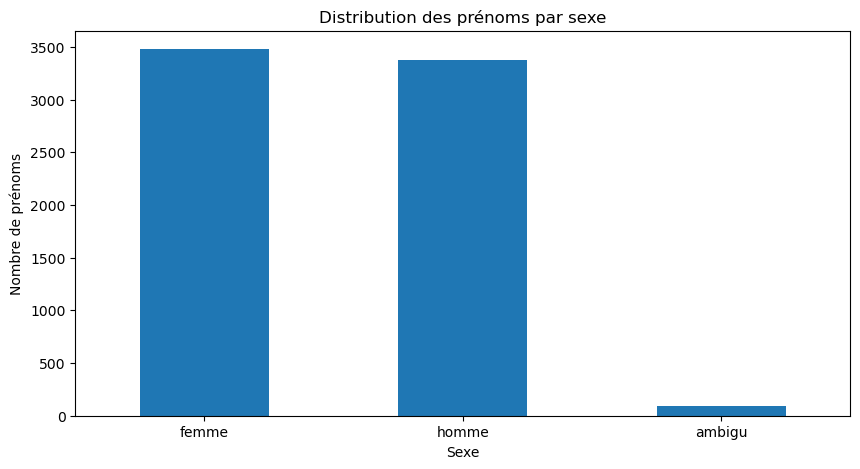

In [11]:
# Nombre de prénoms par sexe
print(df_freq['proba_sexe'].value_counts())

# Pourcentage de prénoms par sexe
print(df_freq['proba_sexe'].value_counts(normalize=True) * 100)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
df_freq['proba_sexe'].value_counts().plot(kind='bar')
plt.title('Distribution des prénoms par sexe')
plt.xlabel('Sexe')
plt.ylabel('Nombre de prénoms')
plt.xticks(rotation=0)
plt.show()


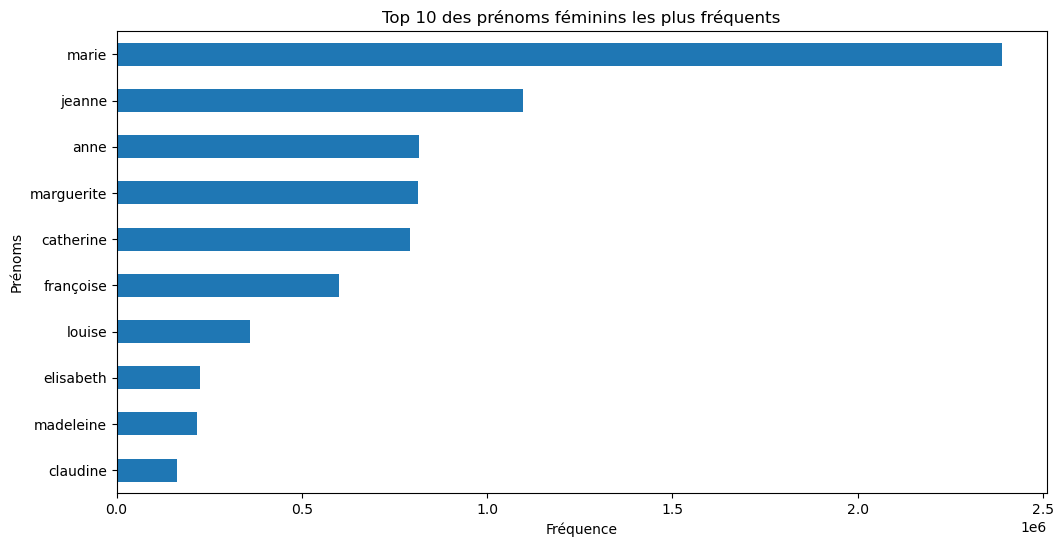

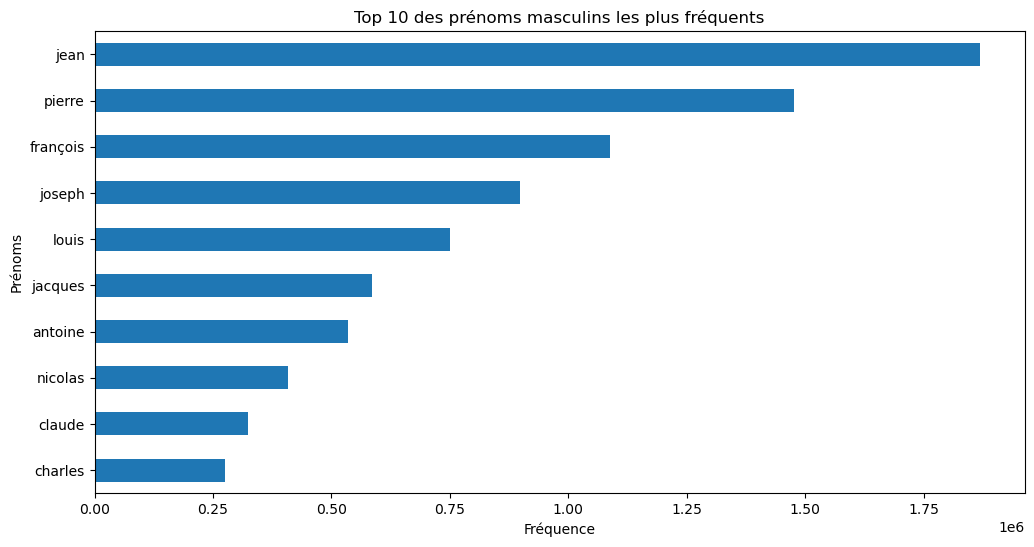

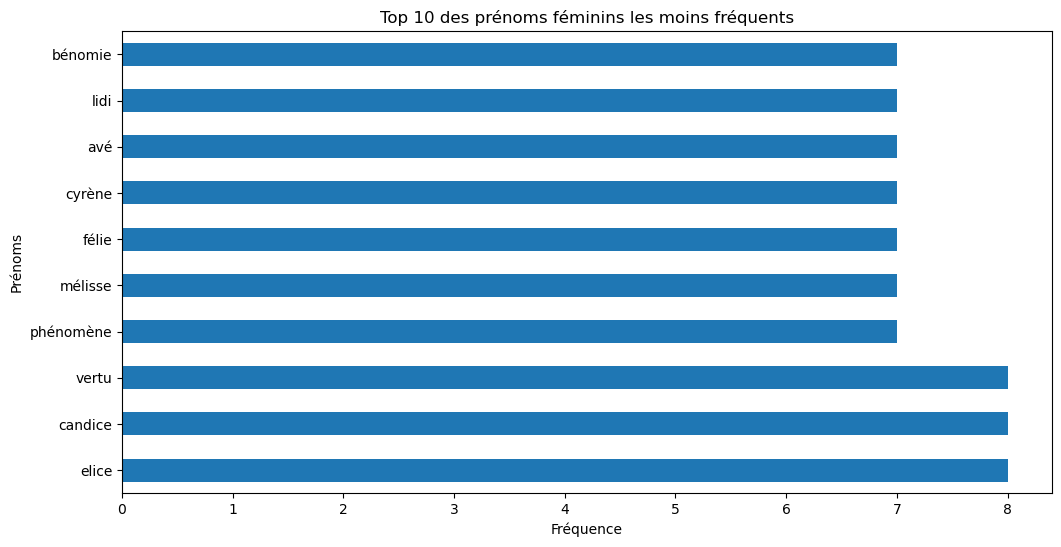

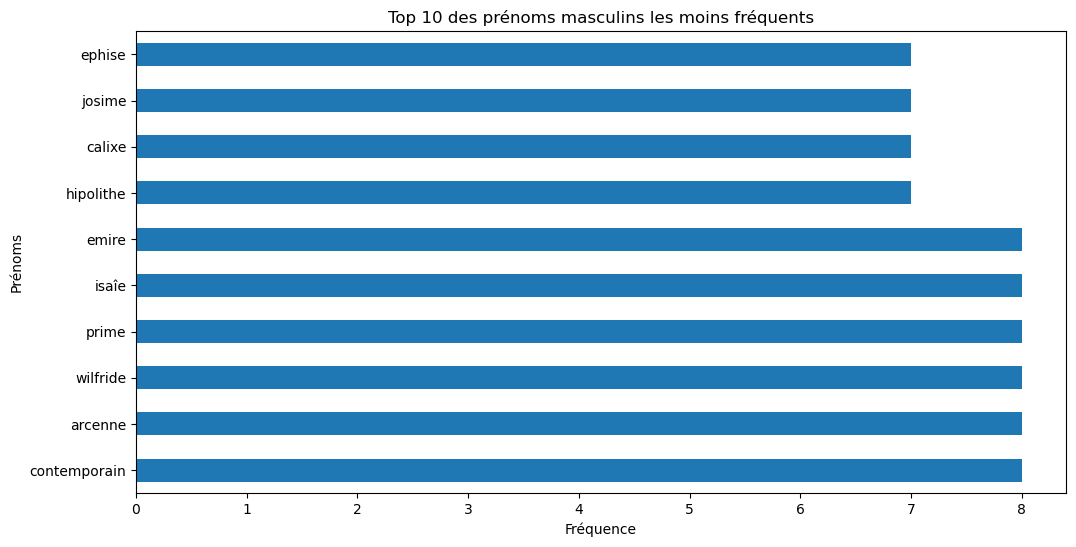

In [12]:
#  10 prénoms féminins les plus fréquents
top_female_names = df_freq[df_freq['proba_sexe'] == 'femme'].nlargest(10, 'female')

plt.figure(figsize=(12, 6))
top_female_names.set_index('firstname')['female'].plot(kind='barh')
plt.title('Top 10 des prénoms féminins les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Prénoms')
plt.gca().invert_yaxis()
plt.show()

#  10 prénoms masculins les plus fréquents
top_male_names = df_freq[df_freq['proba_sexe'] == 'homme'].nlargest(10, 'male')

plt.figure(figsize=(12, 6))
top_male_names.set_index('firstname')['male'].plot(kind='barh')
plt.title('Top 10 des prénoms masculins les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Prénoms')
plt.gca().invert_yaxis()
plt.show()

# 10 prénoms féminins les moins fréquents
bottom_female_names = df_freq[(df_freq['proba_sexe'] == 'femme') & (df_freq['female'] > 0)].nsmallest(10, 'female')

plt.figure(figsize=(12, 6))
bottom_female_names.set_index('firstname')['female'].plot(kind='barh')
plt.title('Top 10 des prénoms féminins les moins fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Prénoms')
plt.gca().invert_yaxis()
plt.show()

#10 prénoms masculins les moins fréquents
bottom_male_names = df_freq[(df_freq['proba_sexe'] == 'homme') & (df_freq['male'] > 0)].nsmallest(10, 'male')

plt.figure(figsize=(12, 6))
bottom_male_names.set_index('firstname')['male'].plot(kind='barh')
plt.title('Top 10 des prénoms masculins les moins fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Prénoms')
plt.gca().invert_yaxis()
plt.show()


**Dataset transcription, Test set**

In [13]:
df_transcription = pd.read_csv('transcriptions_with_sex.csv')
df_transcription.head()

,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme


In [14]:
df_transcription.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subject_line  241 non-null    object
 1   groundtruth   241 non-null    object
 2   prediction    241 non-null    object
 3   sex           241 non-null    object
dtypes: object(4)
memory usage: 7.7+ KB


In [15]:
# prénoms de groundtruth et prediction
def extract_groundtruth_firstname(text):
    match = re.search(r"firstname:\s*([^\s]+)", text)
    return match.group(1) if match else None

def extract_prediction_firstname(text):
    match = re.search(r"prénom:\s*([^\s]+)", text)
    return match.group(1) if match else None


df_transcription['groundtruth_firstname'] = df_transcription['groundtruth'].apply(extract_groundtruth_firstname)
df_transcription['prediction_firstname'] = df_transcription['prediction'].apply(extract_prediction_firstname)


df_transcription = df_transcription[['groundtruth_firstname', 'prediction_firstname', 'sex']]



In [16]:
print(df_transcription)

    groundtruth_firstname prediction_firstname    sex
0                   Marie                Marie  femme
1              Louis-Jean                Louis  homme
2                   Marie                Marie  femme
3                   Marie                Marie  femme
4              Marguerite           Marguerite  femme
..                    ...                  ...    ...
236            Pétronille           Gihromille  femme
237             Alexandre            Alexandre  homme
238            Marguerite           Marguerite  femme
239               Etienne              Etienne  homme
240            Antoinette           Antoinette  femme

[241 rows x 3 columns]


In [17]:
# valeurs uniques de la colonne 'sex'
unique_sex_values = df_transcription['sex'].unique()
print(unique_sex_values)

['femme' 'homme' 'ambigu']


In [18]:
#  prénoms 'ambigu'
ambiguous_names = df_transcription[df_transcription['sex'] == 'ambigu']

print(ambiguous_names[['groundtruth_firstname', 'prediction_firstname']])


    groundtruth_firstname prediction_firstname
17                 Claude               Claude
59                 Jeanne               Jeanne
94                 Claude                Vaude
123                 Marie                Marie
124                 Emile                Emile
130                 Marie                Marie
196                Claude               Claude
204               Antonie              Entonie
230                Claude               Claude


# Prediction

In [43]:
#cible en mappant le sexe aux valeurs numériques
df_freq['target'] = df_freq['proba_sexe'].map({'femme': 0, 'homme': 1, 'ambigu': 2})

#caractéristiques des prénoms
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
X = vectorizer.fit_transform(df_freq['firstname'])
y = df_freq['target']

In [44]:
print(y)

0       0
1       1
2       1
3       0
4       1
       ..
6941    1
6942    1
6943    0
6944    1
6945    0
Name: target, Length: 6946, dtype: int64


**SVM**

**Entrainement train set**

In [45]:
model_svm = SVC(kernel='rbf')
model_svm.fit(X, y)

# Prédiction sur le train set pour évaluer comment le modèle a appris
train_predictions = model_svm.predict(X)

# Évaluation 
train_accuracy = accuracy_score(y, train_predictions)
print(f"Training set accuracy: {train_accuracy * 100:.2f}%")
print("Classification report on training set:")
print(classification_report(y, train_predictions))

Training set accuracy: 94.20%
Classification report on training set:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3480
           1       0.93      0.97      0.95      3378
           2       1.00      0.03      0.07        88

    accuracy                           0.94      6946
   macro avg       0.96      0.65      0.65      6946
weighted avg       0.94      0.94      0.94      6946



**entrainement test set**

In [46]:
#jeu de test
X_transcription = vectorizer.transform(df_transcription['prediction_firstname'])

# Prédiction du sexe sur les prénoms de transcription
df_transcription['predicted_sexe'] = model_svm.predict(X_transcription)
df_transcription['predicted_sexe'] = df_transcription['predicted_sexe'].map({0: 'femme', 1: 'homme', 2: 'ambigu'})

# Mappage des étiquettes réelles 
df_transcription['sex_encoded'] = df_transcription['sex'].map({'femme': 0, 'homme': 1, 'ambigu': 2}) #la colonne sex sont les etiquettes reelles on les encode ici
df_transcription['predicted_sexe_encoded'] = df_transcription['predicted_sexe'].map({'femme': 0, 'homme': 1, 'ambigu': 2})


# accuracy sur le test set
test_accuracysvc = accuracy_score(df_transcription['sex_encoded'], df_transcription['predicted_sexe_encoded'])


print(df_transcription[['prediction_firstname', 'predicted_sexe']])
print(f"Test set accuracy: {test_accuracysvc * 100:.2f}%")


    prediction_firstname predicted_sexe
0                  Marie          femme
1                  Louis          homme
2                  Marie          femme
3                  Marie          femme
4             Marguerite          femme
..                   ...            ...
236           Gihromille          homme
237            Alexandre          homme
238           Marguerite          femme
239              Etienne          femme
240           Antoinette          femme

[241 rows x 2 columns]
Test set accuracy: 87.14%


In [47]:
test_accuracysvc = accuracy_score(df_transcription['sex_encoded'], df_transcription['predicted_sexe_encoded'])

print(df_transcription[['prediction_firstname', 'predicted_sexe']])
print(f"Test set accuracy: {test_accuracysvc * 100:.2f}%")
print("Classification report on test set:")
print(classification_report(df_transcription['sex_encoded'], df_transcription['predicted_sexe_encoded'], target_names=['femme', 'homme', 'ambigu']))

    prediction_firstname predicted_sexe
0                  Marie          femme
1                  Louis          homme
2                  Marie          femme
3                  Marie          femme
4             Marguerite          femme
..                   ...            ...
236           Gihromille          homme
237            Alexandre          homme
238           Marguerite          femme
239              Etienne          femme
240           Antoinette          femme

[241 rows x 2 columns]
Test set accuracy: 87.14%
Classification report on test set:
              precision    recall  f1-score   support

       femme       0.80      0.96      0.88       107
       homme       0.95      0.86      0.90       125
      ambigu       0.00      0.00      0.00         9

    accuracy                           0.87       241
   macro avg       0.58      0.61      0.59       241
weighted avg       0.85      0.87      0.86       241



/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Les warnings « Precision is ill-defined and being set to 0.0 in labels with no predicted samples » signifient que le modèle n'a pas prédit certaines classes du tout, ce qui entraîne une division par zéro lors du calcul de la précision pour ces classes. C'est notamment le cas pour la classe ambigu qui est très peu représentée et difficile à prédire.

In [48]:
# Trouver les prénoms mal prédits
incorrect_predictions = df_transcription[df_transcription['sex_encoded'] != df_transcription['predicted_sexe_encoded']]

# Afficher les prénoms mal prédits avec leur sexe réel et le sexe prédit
incorrect_predictions[['prediction_firstname', 'sex', 'predicted_sexe']].count()

prediction_firstname    31
sex                     31
predicted_sexe          31
dtype: int64

### **XGBoost**

**Entrainement sur le train set**

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


df_freq['target'] = df_freq['proba_sexe'].map({'femme': 0, 'homme': 1, 'ambigu': 2})

vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
X = vectorizer.fit_transform(df_freq['firstname'])
y = df_freq['target']


param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X, y)

print(f"Best parameters found: {grid_search.best_params_}")

# Entraînement 
optimized_xgb_model = XGBClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_depth=grid_search.best_params_['max_depth'],
    learning_rate=grid_search.best_params_['learning_rate'],
    use_label_encoder=False,
    eval_metric='logloss'
)
optimized_xgb_model.fit(X, y)

# Évaluation sur le train set
train_predictions_xgb = optimized_xgb_model.predict(X)
train_accuracy_xgb = accuracy_score(y, train_predictions_xgb)
print(f"Training set accuracy: {train_accuracy_xgb * 100:.2f}%")
print("Classification report on training set:")
print(classification_report(y, train_predictions_xgb))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Training set accuracy: 92.74%
Classification report on training set:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3480
           1       0.91      0.96      0.93      3378
           2       1.00      0.26      0.41        88

    accuracy                           0.93      6946
   macro avg       0.95      0.71      0.76      6946
weighted avg       0.93      0.93      0.93      6946

[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=   6.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   2.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   5.3s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   1.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   2.6s
[

**Entrainement sur le test set**

In [50]:
# Transformation des prénoms 
X_transcription = vectorizer.transform(df_transcription['prediction_firstname'])

# Prédiction du sexe sur les prénoms de transcription
df_transcription['predicted_sexe'] = optimized_xgb_model.predict(X_transcription)
df_transcription['predicted_sexe'] = df_transcription['predicted_sexe'].map({0: 'femme', 1: 'homme', 2: 'ambigu'})

df_transcription['sex_encoded'] = df_transcription['sex'].map({'femme': 0, 'homme': 1, 'ambigu': 2})
df_transcription['predicted_sexe_encoded'] = df_transcription['predicted_sexe'].map({'femme': 0, 'homme': 1, 'ambigu': 2})


test_accuracy = accuracy_score(df_transcription['sex_encoded'], df_transcription['predicted_sexe_encoded'])
print(f"Test set accuracy: {test_accuracy * 100:.2f}%")


Test set accuracy: 90.04%


In [51]:
# Affichage du rapport de classification
print("Classification Report for Test Set:")
print(classification_report(df_transcription['sex_encoded'], df_transcription['predicted_sexe_encoded'], target_names=['femme', 'homme', 'ambigu']))

Classification Report for Test Set:
              precision    recall  f1-score   support

       femme       0.85      0.97      0.90       107
       homme       0.96      0.90      0.93       125
      ambigu       0.00      0.00      0.00         9

    accuracy                           0.90       241
   macro avg       0.60      0.63      0.61       241
weighted avg       0.87      0.90      0.88       241



/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Les warnings « Precision is ill-defined and being set to 0.0 in labels with no predicted samples » signifient que le modèle n'a pas prédit certaines classes du tout, ce qui entraîne une division par zéro lors du calcul de la précision pour ces classes. C'est notamment le cas pour la classe ambigu qui est très peu représentée et difficile à prédire.

Le score est tout de même meilleur qu'avec SVM

In [64]:
# Trouver les prénoms mal prédits
incorrect_predictions_xgb = df_transcription[df_transcription['sex_encoded'] != df_transcription['predicted_sexe_encoded']]

# Afficher les prénoms mal prédits avec leur sexe réel et le sexe prédit
print(incorrect_predictions_xgb[['prediction_firstname', 'sex', 'predicted_sexe']].count())
print(incorrect_predictions_xgb[['prediction_firstname', 'sex', 'predicted_sexe']])

prediction_firstname    19
sex                     19
predicted_sexe          19
dtype: int64
    prediction_firstname     sex predicted_sexe
17                Claude  ambigu          homme
59                Jeanne  ambigu          femme
62            Jean-Marie   homme          femme
65              Angloise   homme          femme
94                 Vaude  ambigu          femme
123                Marie  ambigu          femme
124                Emile  ambigu          homme
130                Marie  ambigu          femme
142               Aupène   homme          femme
146                Marie   homme          femme
188                 Anne   homme          femme
193               Marthy   femme          homme
196               Claude  ambigu          homme
197                 Faul   femme          homme
204              Entonie  ambigu          femme
219               Franco   femme          homme
228               Simone   homme          femme
230               Claude  ambigu          

on a effectivement moins d'erreurs

### **Random Forest**

In [54]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X, y)

train_predictions = model_rf.predict(X)
train_accuracy = accuracy_score(y, train_predictions)
print(f"Training set accuracy: {train_accuracy * 100:.2f}%")
print("Classification report on training set:")
print(classification_report(y, train_predictions, target_names=['femme', 'homme', 'ambigu']))

Training set accuracy: 99.93%
Classification report on training set:
              precision    recall  f1-score   support

       femme       1.00      1.00      1.00      3480
       homme       1.00      1.00      1.00      3378
      ambigu       1.00      0.95      0.98        88

    accuracy                           1.00      6946
   macro avg       1.00      0.98      0.99      6946
weighted avg       1.00      1.00      1.00      6946



In [58]:
df_transcription['sex_encoded'] = df_transcription['sex'].map({'femme': 0, 'homme': 1, 'ambigu': -1})
df_transcription['predicted_sexe_encoded'] = df_transcription['predicted_sexe'].map({'femme': 0, 'homme': 1, 'ambigu': -1})

accuracyrf = accuracy_score(df_transcription['sex_encoded'], df_transcription['predicted_sexe_encoded'])

print(f"Accuracy of the model: {accuracyrf * 100:.2f}%")

Accuracy of the model: 92.12%


In [61]:
#mauvaises prédictions
incorrect_predictions_with_groundtruth = df_transcription[
    (df_transcription['sex_encoded'] != df_transcription['predicted_sexe_encoded'])
][['groundtruth_firstname', 'prediction_firstname', 'sex', 'predicted_sexe']]

print(incorrect_predictions_with_groundtruth)
incorrect_predictions_with_groundtruth.count()


    groundtruth_firstname prediction_firstname     sex predicted_sexe
17                 Claude               Claude  ambigu          homme
59                 Jeanne               Jeanne  ambigu          femme
62             Jean-Marie           Jean-Marie   homme          femme
65                Antoine             Angloise   homme          femme
94                 Claude                Vaude  ambigu          femme
123                 Marie                Marie  ambigu          femme
124                 Emile                Emile  ambigu          homme
130                 Marie                Marie  ambigu          femme
142               Antoine               Aupène   homme          femme
146                 Marie                Marie   homme          femme
188                Pierre                 Anne   homme          femme
193                Marthe               Marthy   femme          homme
196                Claude               Claude  ambigu          homme
197             Fran

groundtruth_firstname    19
prediction_firstname     19
sex                      19
predicted_sexe           19
dtype: int64

Ce modèle est beaucoup plus performant que le précédent (on retrouve moins d'erreurs)

In [65]:
!pip install thefuzz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.7 MB/s eta 0:00:0000:0100:01


In [66]:
from thefuzz import process

#prénoms connus à partir des données de groundtruth
known_firstnames = df_transcription['groundtruth_firstname'].unique()

#corriger les prénoms en utilisant la correspondance la plus proche
def correct_firstname(name, known_names):
   
    corrected_name, score = process.extractOne(name, known_names)
  
    threshold = 70  
    return corrected_name if score >= threshold else name


df_transcription['corrected_prediction_firstname'] = df_transcription['prediction_firstname'].apply(
    lambda x: correct_firstname(x, known_firstnames)
)



In [67]:
df_freq['target'] = df_freq['proba_sexe'].map({'femme': 0, 'homme': 1, 'ambigu': 2})

vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
X = vectorizer.fit_transform(df_freq['firstname'])
y = df_freq['target']

In [68]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# vectorizer ajusté 
X_transcription_corrected = vectorizer.transform(df_transcription['corrected_prediction_firstname'])


df_transcription['predicted_sexe'] = model.predict(X_transcription_corrected)


df_transcription['predicted_sexe'] = df_transcription['predicted_sexe'].map({0: 'femme', 1: 'homme', 2: 'ambigu'})


print(df_transcription[['corrected_prediction_firstname', 'predicted_sexe']])

#accuracy 
df_transcription['sex_encoded'] = df_transcription['sex'].map({'femme': 0, 'homme': 1, 'ambigu': 2})
df_transcription['predicted_sexe_encoded'] = df_transcription['predicted_sexe'].map({'femme': 0, 'homme': 1, 'ambigu': 2})
accuracy_rf_corrected = accuracy_score(df_transcription['sex_encoded'], df_transcription['predicted_sexe_encoded'])

print(f"Accuracy of the corrected model: {accuracy_rf_corrected * 100:.2f}%")


    corrected_prediction_firstname predicted_sexe
0                            Marie          femme
1                            Louis          homme
2                            Marie          femme
3                            Marie          femme
4                       Marguerite          femme
..                             ...            ...
236                          Emile          homme
237                      Alexandre          homme
238                     Marguerite          femme
239                        Etienne          homme
240                     Antoinette          femme

[241 rows x 2 columns]
Accuracy of the corrected model: 92.53%


In [69]:
# prénoms mal prédits
incorrect_predictions = df_transcription[df_transcription['sex_encoded'] != df_transcription['predicted_sexe_encoded']]

# Afficher les prénoms mal prédits avec leur sexe réel et le sexe prédit
incorrect_predictions[['groundtruth_firstname', 'prediction_firstname', 'sex', 'predicted_sexe']]

,groundtruth_firstname,prediction_firstname,sex,predicted_sexe
17,Claude,Claude,ambigu,homme
18,Antoine,Angène,homme,femme
59,Jeanne,Jeanne,ambigu,femme
62,Jean-Marie,Jean-Marie,homme,femme
65,Antoine,Angloise,homme,femme
94,Claude,Vaude,ambigu,homme
123,Marie,Marie,ambigu,femme
124,Emile,Emile,ambigu,homme
130,Marie,Marie,ambigu,femme
142,Antoine,Aupène,homme,femme


#### Test avec word embedding

Bien que nous ayions eu de bons résultats avec random forest, on peut essyaer une technique de word embedding pour capturer les nuances linguistiques et culturelles des prénoms

In [76]:
! pip install spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 23.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.9/490.9 kB 11.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.1/920.1 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [79]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 26.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [81]:
import spacy
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Chargement du modèle spaCy
nlp = spacy.load('en_core_web_md')

# convertir les prénoms en vecteurs de plongements de mots
class SpacyVectorizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([nlp(name).vector for name in X])

# Mappage étiquettes
df_freq['target'] = df_freq['proba_sexe'].map({'femme': 0, 'homme': 1, 'ambigu': 2})

# Séparation ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df_freq['firstname'], df_freq['target'], test_size=0.2, random_state=42)


pipeline = Pipeline([
    ('vectorizer', SpacyVectorizer()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entraînement du modèle
pipeline.fit(X_train, y_train)

# Prédiction et évaluation 
predicted = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f"Test set accuracy: {accuracy * 100:.2f}%")
print("Classification report on test set:")
print(classification_report(y_test, predicted))

Test set accuracy: 56.76%
Classification report on test set:
              precision    recall  f1-score   support

           0       0.55      0.95      0.69       714
           1       0.74      0.17      0.28       660
           2       1.00      0.06      0.12        16

    accuracy                           0.57      1390
   macro avg       0.76      0.39      0.36      1390
weighted avg       0.64      0.57      0.49      1390

